# EDA and Feature Engineering for Sales

In [63]:
#from source.dataspark_constants import ROW_DATA_PATH , PROCESSED_DATA_PATH
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer ,KNNImputer
import os

In [64]:

print(os.getcwd())
df = pd.read_csv(r"..\Datasets\Sales.csv" ,  encoding='ISO-8859-1')
df.columns

C:\DataScience\habro-EDA-pre-processing\pre_processing


Index(['Order Number', 'Line Item', 'Order Date', 'Delivery Date',
       'CustomerKey', 'StoreKey', 'ProductKey', 'Quantity', 'Currency Code'],
      dtype='object')

##### Dimension of Data

In [65]:
df.shape

(62884, 9)

##### Checking Duplications and Missing Values

In [66]:
df.duplicated().sum()   # no duplications
df.isnull().sum()

Order Number         0
Line Item            0
Order Date           0
Delivery Date    49719
CustomerKey          0
StoreKey             0
ProductKey           0
Quantity             0
Currency Code        0
dtype: int64

##### Handling Missing delivery date (KNN imputer)

In [67]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], format='%m/%d/%Y')

# Calculate days since minimum order date
df['OrderDateDays'] = (df['Order Date'] - df['Order Date'].min()).dt.days

# Calculate days of the year for delivery dates (to use as numerical feature)
df['DeliveryDateDays'] = (df['Delivery Date'] - df['Order Date'].min()).dt.days

# KNN Imputation
imputer = KNNImputer(n_neighbors=3)
df[['OrderDateDays', 'DeliveryDateDays']] = imputer.fit_transform(df[['OrderDateDays', 'DeliveryDateDays']])

# Convert days back to dates
df['Delivery Date'] = pd.to_datetime(df['Order Date'].min()) + pd.to_timedelta(df['DeliveryDateDays'], unit='D')

# Drop intermediate columns
df.drop(columns=['OrderDateDays', 'DeliveryDateDays'], inplace=True)



In [68]:
df.isnull().sum()

Order Number     0
Line Item        0
Order Date       0
Delivery Date    0
CustomerKey      0
StoreKey         0
ProductKey       0
Quantity         0
Currency Code    0
dtype: int64

##### creating new Feature YEAR

In [69]:
df['Year'] = df['Delivery Date'].dt.year
df['Year']

0        2016
1        2016
2        2016
3        2016
4        2016
         ... 
62879    2021
62880    2021
62881    2021
62882    2021
62883    2021
Name: Year, Length: 62884, dtype: int32

In [70]:
df

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code,Year
0,366000,1,2016-01-01,2016-01-10 16:00:00.000000002,265598,10,1304,1,CAD,2016
1,366001,1,2016-01-01,2016-01-13 00:00:00.000000000,1269051,0,1048,2,USD,2016
2,366001,2,2016-01-01,2016-01-13 00:00:00.000000000,1269051,0,2007,1,USD,2016
3,366002,1,2016-01-01,2016-01-12 00:00:00.000000000,266019,0,1106,7,CAD,2016
4,366002,2,2016-01-01,2016-01-12 00:00:00.000000000,266019,0,373,1,CAD,2016
...,...,...,...,...,...,...,...,...,...,...
62879,2243030,1,2021-02-20,2021-02-24 07:59:59.999999997,1216913,43,632,3,USD,2021
62880,2243031,1,2021-02-20,2021-02-24 00:00:00.000000000,511229,0,98,4,EUR,2021
62881,2243032,1,2021-02-20,2021-02-23 00:00:00.000000000,331277,0,1613,2,CAD,2021
62882,2243032,2,2021-02-20,2021-02-23 00:00:00.000000000,331277,0,1717,2,CAD,2021


## EDA

##### Outlier detection

In [71]:
numerical_colomns =[item for item in df.columns if df[item].dtype != 'O']
numerical_colomns

['Order Number',
 'Line Item',
 'Order Date',
 'Delivery Date',
 'CustomerKey',
 'StoreKey',
 'ProductKey',
 'Quantity',
 'Year']

##### concatnating sales and products.

In [72]:

df.to_csv(r".\Sales.csv")
products=pd.read_csv(r"..\Datasets\Products.csv")
print(products.columns)
customers =pd.read_csv(r"..\processed_data\Customers.csv")
sales =df
#products.drop(columns=['Unnamed: 0'],inplace=True)




Index(['ProductKey', 'Product Name', 'Brand', 'Color', 'Unit Cost USD',
       'Unit Price USD', 'SubcategoryKey', 'Subcategory', 'CategoryKey',
       'Category'],
      dtype='object')


In [73]:
products_sales = pd.merge(sales,products,on='ProductKey',how="left")
products_sales
print(products_sales.columns)
products_sales.groupby(by=['Brand','Year']).agg("count")


Index(['Order Number', 'Line Item', 'Order Date', 'Delivery Date',
       'CustomerKey', 'StoreKey', 'ProductKey', 'Quantity', 'Currency Code',
       'Year', 'Product Name', 'Brand', 'Color', 'Unit Cost USD',
       'Unit Price USD', 'SubcategoryKey', 'Subcategory', 'CategoryKey',
       'Category'],
      dtype='object')


Order Number  Line Item  Order Date  Delivery Date  \
Brand                Year                                                       
A. Datum             2016           240        240         240            240   
                     2017           212        212         212            212   
                     2018           342        342         342            342   
                     2019           641        641         641            641   
                     2020           364        364         364            364   
...                                 ...        ...         ...            ...   
Wide World Importers 2017          1225       1225        1225           1225   
                     2018          2108       2108        2108           2108   
                     2019          2934       2934        2934           2934   
                     2020          1486       1486        1486           1486   
                     2021           153        153         153            153   

                           CustomerKey  StoreKey  ProductKey  Quantity  \
Brand                Year                                                
A. Datum             2016          240       240         240       240   
                     2017          212       212         212       212   
                     2018          342       342         342       342   
                     2019          641       641         641       641   
                     2020          364       364         364       364   
...                                ...       ...         ...       ...   
Wide World Importers 2017         1225      1225        1225      1225   
                     2018         2108      2108        2108      2108   
                     2019         2934      2934        2934      2934   
                     2020         1486      1486        1486      1486   
                     2021          153       153         153       153   

                           Currency Code  Product Name  Color  Unit Cost USD  \
Brand                Year                                                      
A. Datum             2016            240           240    240            240   
                     2017            212           212    212            212   
                     2018            342           342    342            342   
                     2019            641           641    641            641   
                     2020            364           364    364            364   
...                                  ...           ...    ...            ...   
Wide World Importers 2017           1225          1225   1225           1225   
                     2018           2108          2108   2108           2108   
                     2019           2934          2934   2934           2934   
                     2020           1486          1486   1486           1486   
                     2021            153           153    153            153   

                           Unit Price USD  SubcategoryKey  Subcategory  \
Brand                Year                                                
A. Datum             2016             240             240          240   
                     2017             212             212          212   
                     2018             342             342          342   
                     2019             641             641          641   
                     2020             364             364          364   
...                                   ...             ...          ...   
Wide World Importers 2017            1225            1225         1225   
                     2018            2108            2108         2108   
                     2019            2934            2934         2934   
                     2020            1486            1486         1486   
                     2021             153             153          153   

      

##### Merging products , sales and Customers

In [74]:
df = pd.merge(products_sales,customers,on='CustomerKey',how='left')
df
df.columns

Index(['Order Number', 'Line Item', 'Order Date', 'Delivery Date',
       'CustomerKey', 'StoreKey', 'ProductKey', 'Quantity', 'Currency Code',
       'Year', 'Product Name', 'Brand', 'Color', 'Unit Cost USD',
       'Unit Price USD', 'SubcategoryKey', 'Subcategory', 'CategoryKey',
       'Category', 'Unnamed: 0', 'Gender', 'Name', 'City', 'State Code',
       'State', 'Zip Code', 'Country', 'Continent', 'Birthday', 'Age',
       'Age Group'],
      dtype='object')

##### Age Group V/S Purchase 

Index(['Order Number', 'Line Item', 'Order Date', 'Delivery Date',
       'CustomerKey', 'StoreKey', 'ProductKey', 'Quantity', 'Currency Code',
       'Year', 'Product Name', 'Brand', 'Color', 'Unit Cost USD',
       'Unit Price USD', 'SubcategoryKey', 'Subcategory', 'CategoryKey',
       'Category', 'Unnamed: 0', 'Gender', 'Name', 'City', 'State Code',
       'State', 'Zip Code', 'Country', 'Continent', 'Birthday', 'Age',
       'Age Group'],
      dtype='object')


<Axes: xlabel='Age Group', ylabel='Count'>

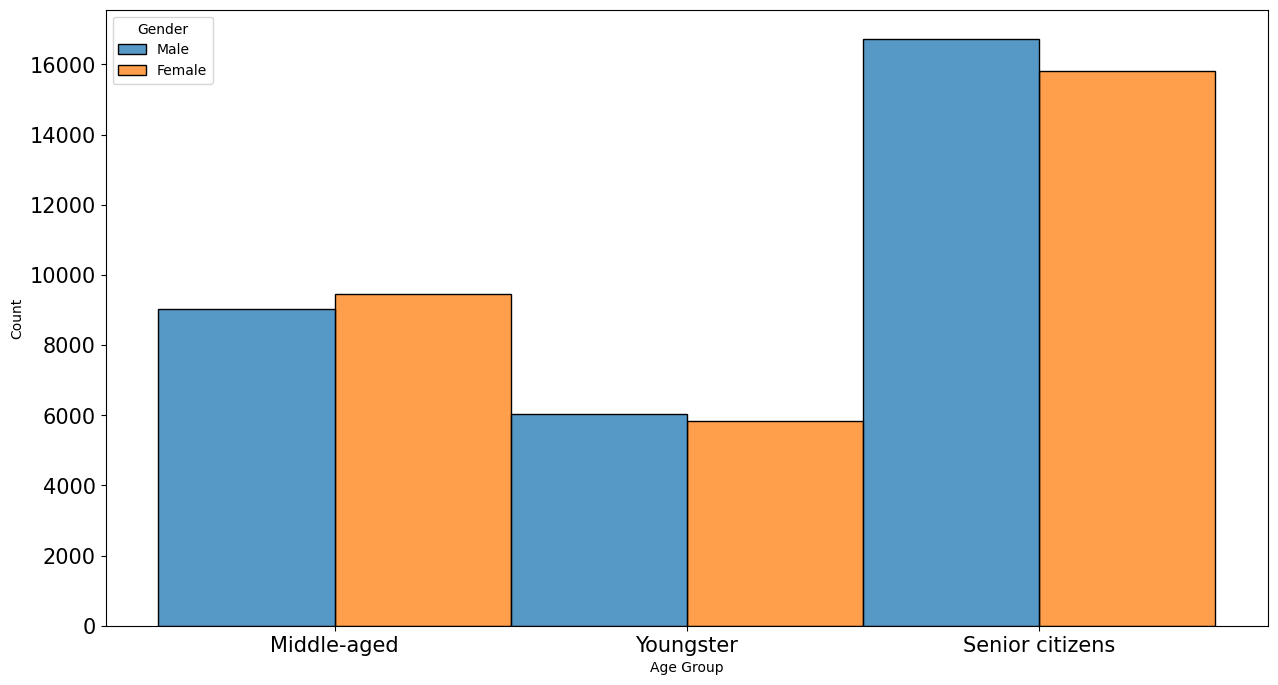

In [75]:
print(df.columns)
plt.figure(figsize=(15, 8)) 
plt.xlabel('Age Group',fontsize =10)
#plt.ylabel('Price(USD)',fontsize =50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.histplot(data =df,x='Age Group',hue = df['Gender'],multiple='dodge')

In [76]:
p=df.groupby(by=['Country'])['Order Number'].count().values
p




array([ 2941,  5415,  1730,  5956,  2685,  2250,  8140, 33767])

##### Sales of Each Brands in Countries

<Axes: xlabel='Brand', ylabel='Count'>

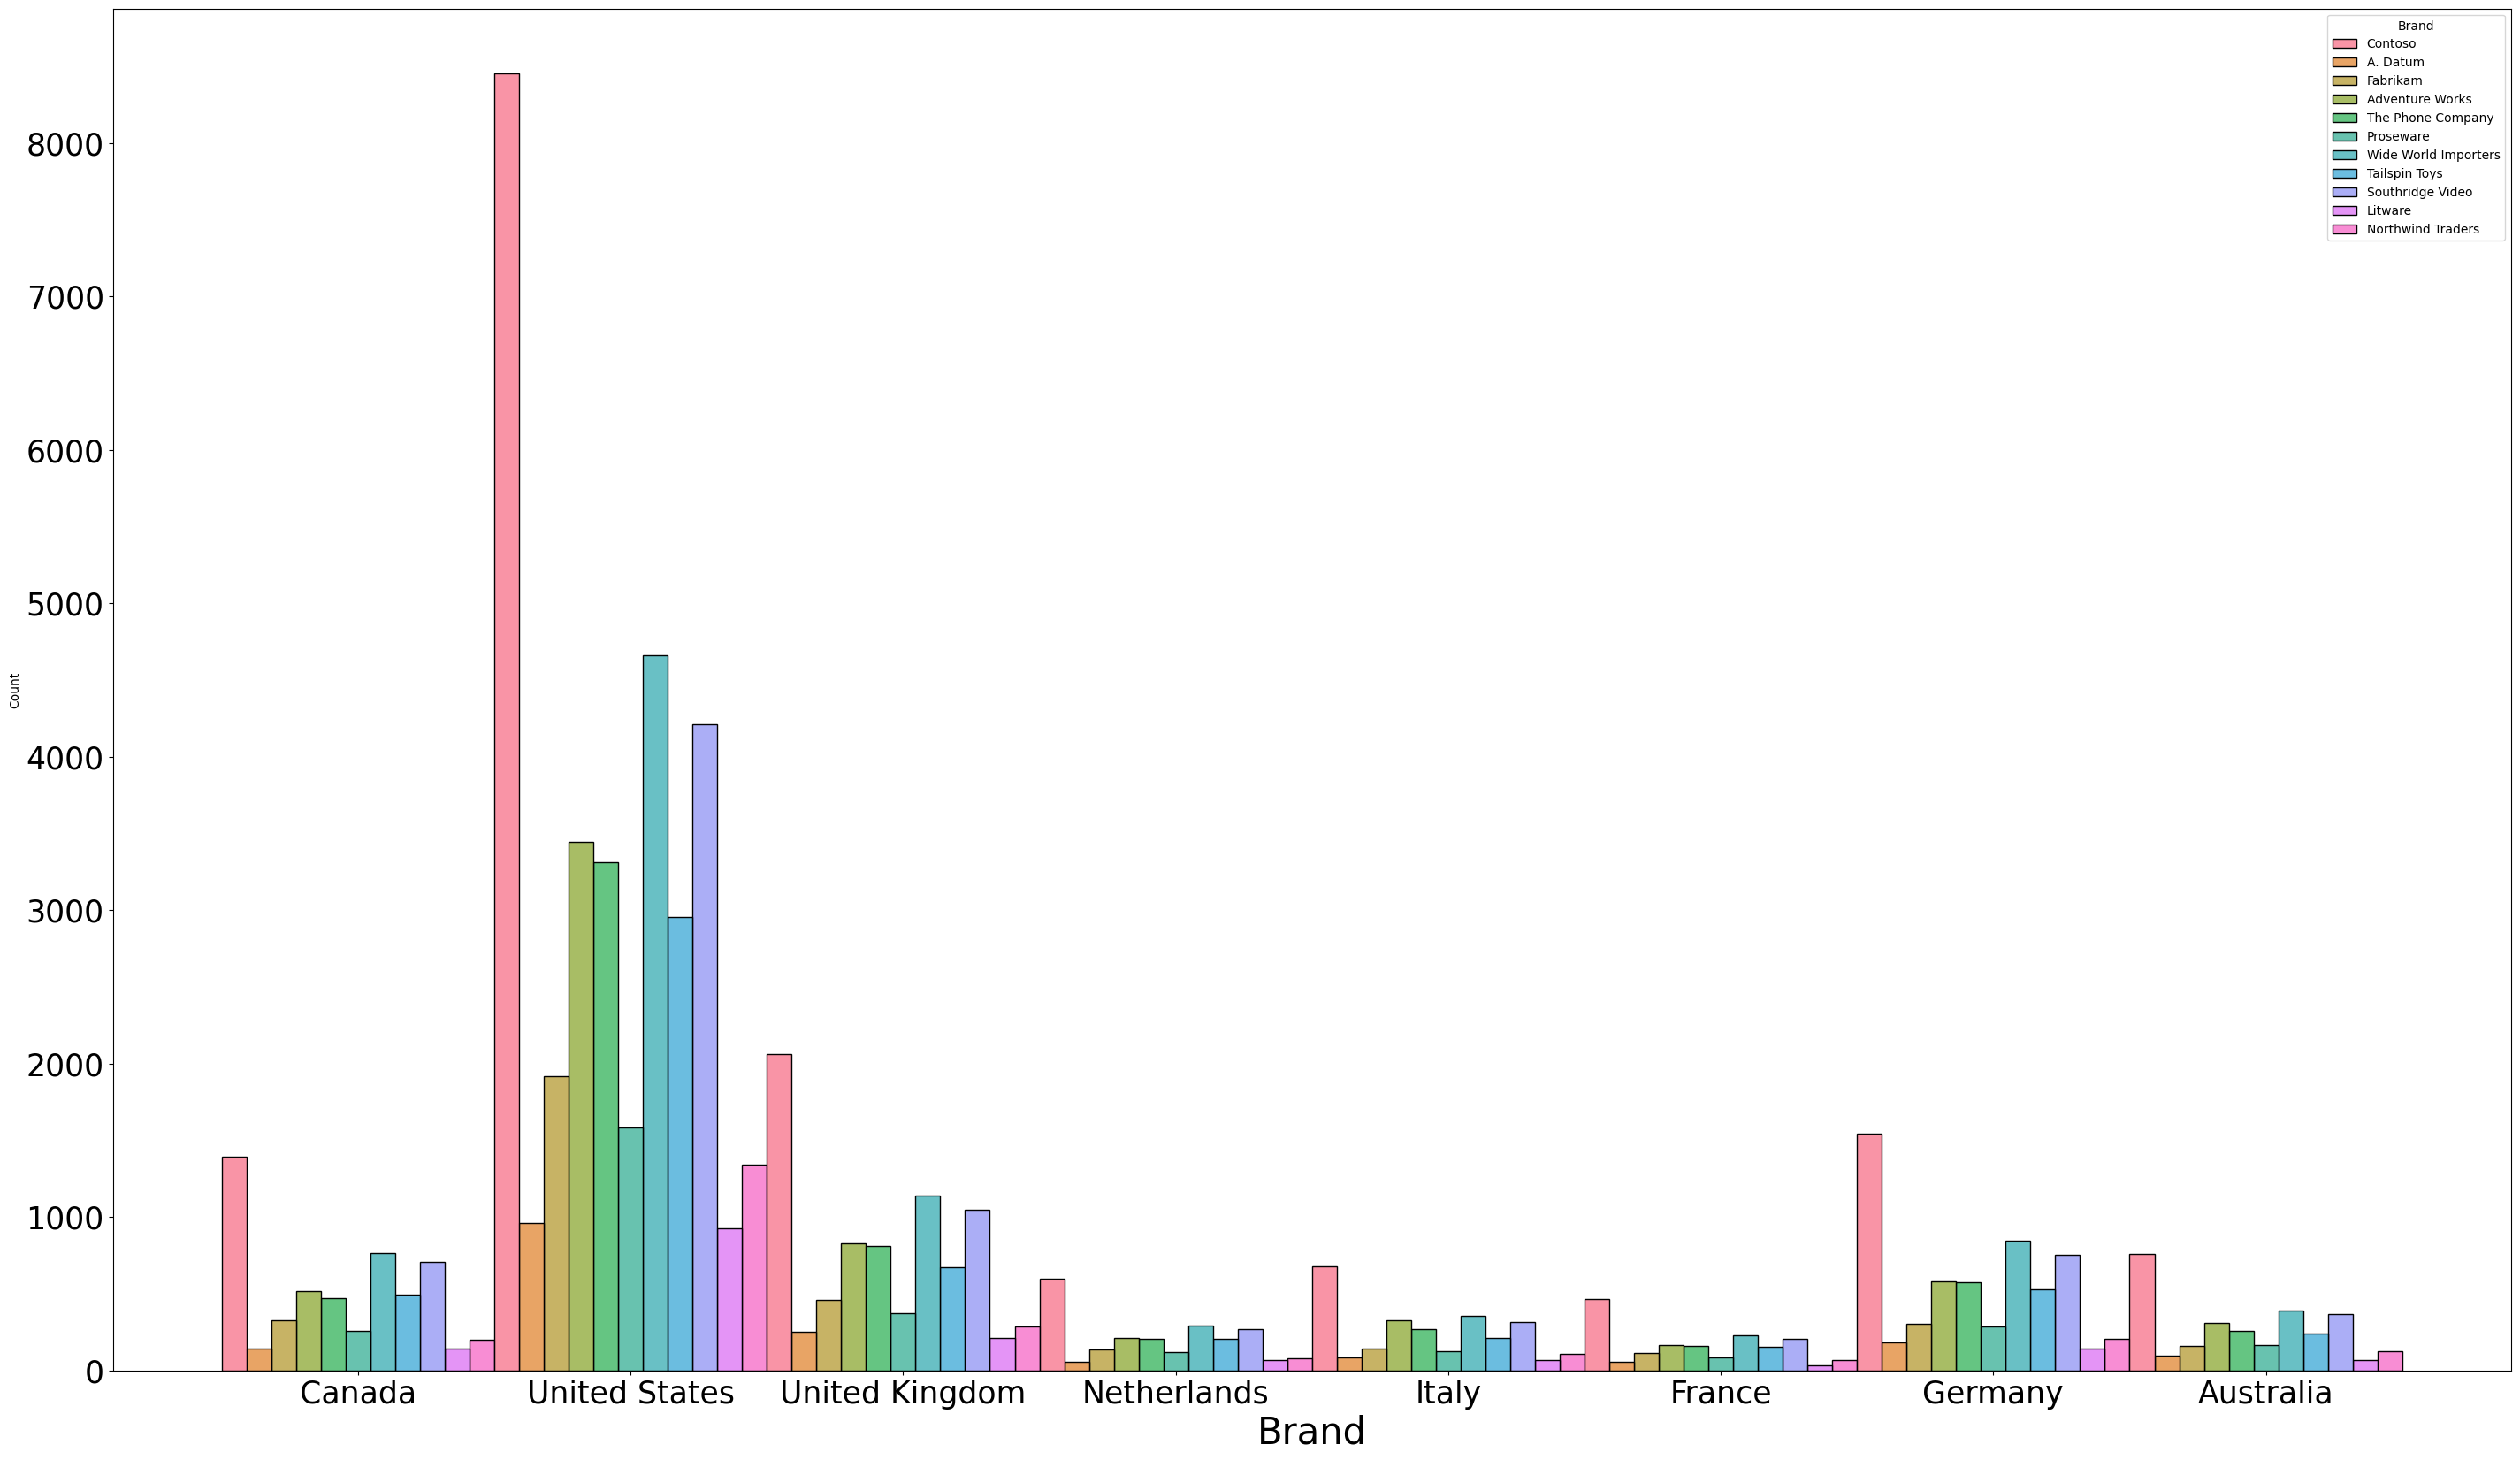

In [77]:
plt.figure(figsize=(35, 20)) 
plt.xlabel('Brand',fontsize =30)
#plt.ylabel('Price(USD)',fontsize =50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sns.histplot(data=df , x=df['Country'],hue=df['Brand'],multiple='dodge')


##### Year wise Sales for Each brand

In [78]:
d =pd.DataFrame( df.groupby(by=['Year','Brand'])['Order Number'].count())
d

Order Number
Year Brand                             
2016 A. Datum                       240
     Adventure Works                731
     Contoso                       1788
     Fabrikam                       505
     Litware                        307
...                                 ...
2021 Proseware                       60
     Southridge Video               185
     Tailspin Toys                  133
     The Phone Company              160
     Wide World Importers           153

[66 rows x 1 columns]

<Axes: xlabel='Year', ylabel='Count'>

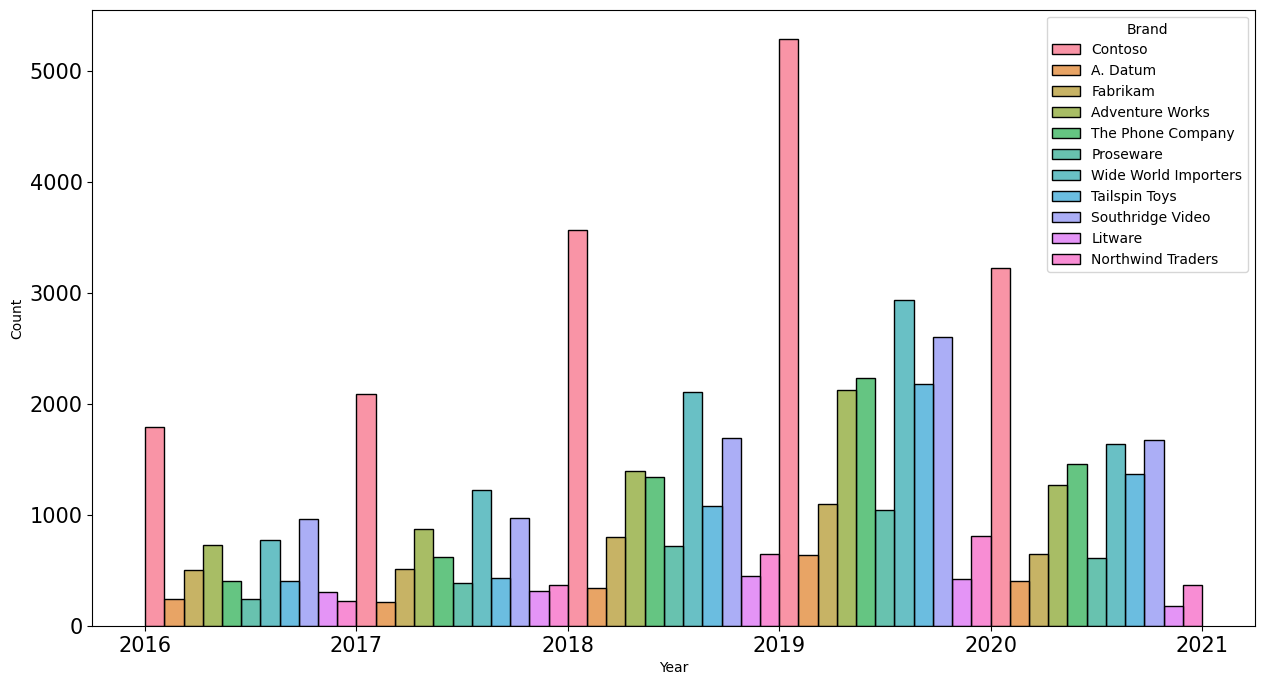

In [79]:
plt.figure(figsize=(15, 8)) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.histplot(data =df ,bins=5 ,x='Year',hue=df['Brand'],multiple='dodge')




##### Yearwise Customer retention rate

<Axes: xlabel='Year', ylabel='Count'>

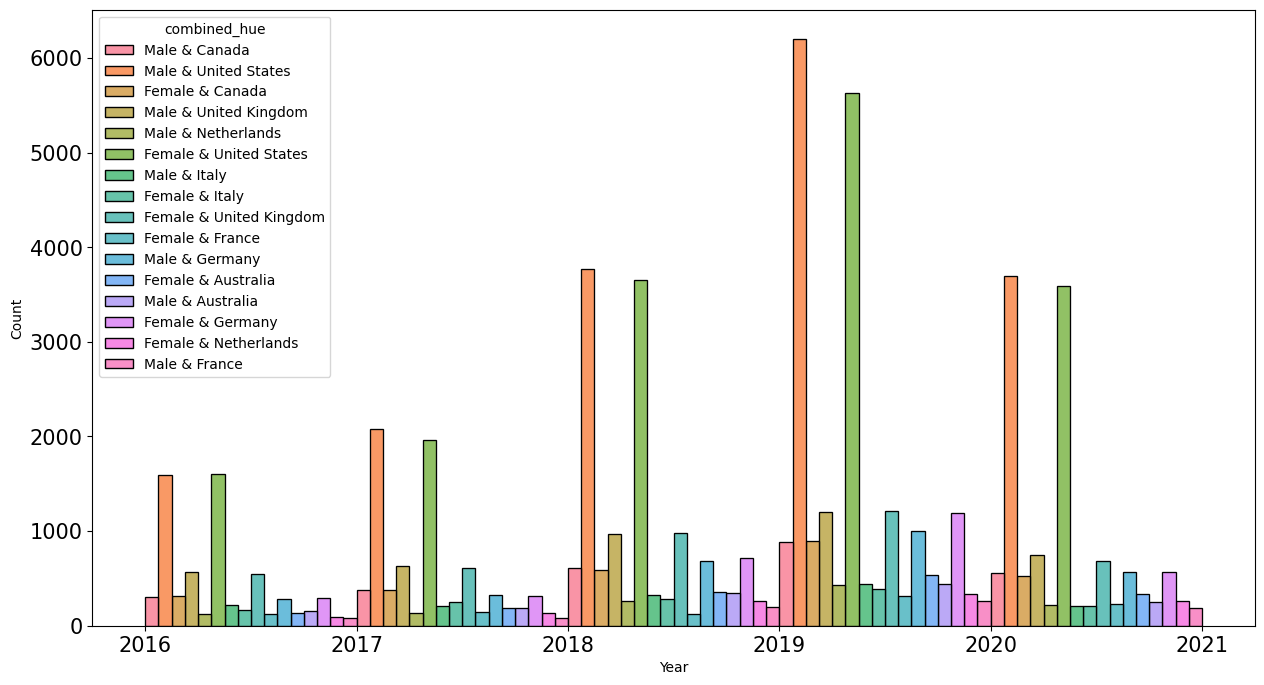

In [80]:
plt.figure(figsize=(15, 8)) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['combined_hue'] = df['Gender'] + ' & ' + df['Country']
sns.histplot(data =df ,bins=5 ,x='Year',hue='combined_hue',multiple='dodge')




##### Year wise sales Insights

Text(0.5, 1.0, 'Year V/s Continent')

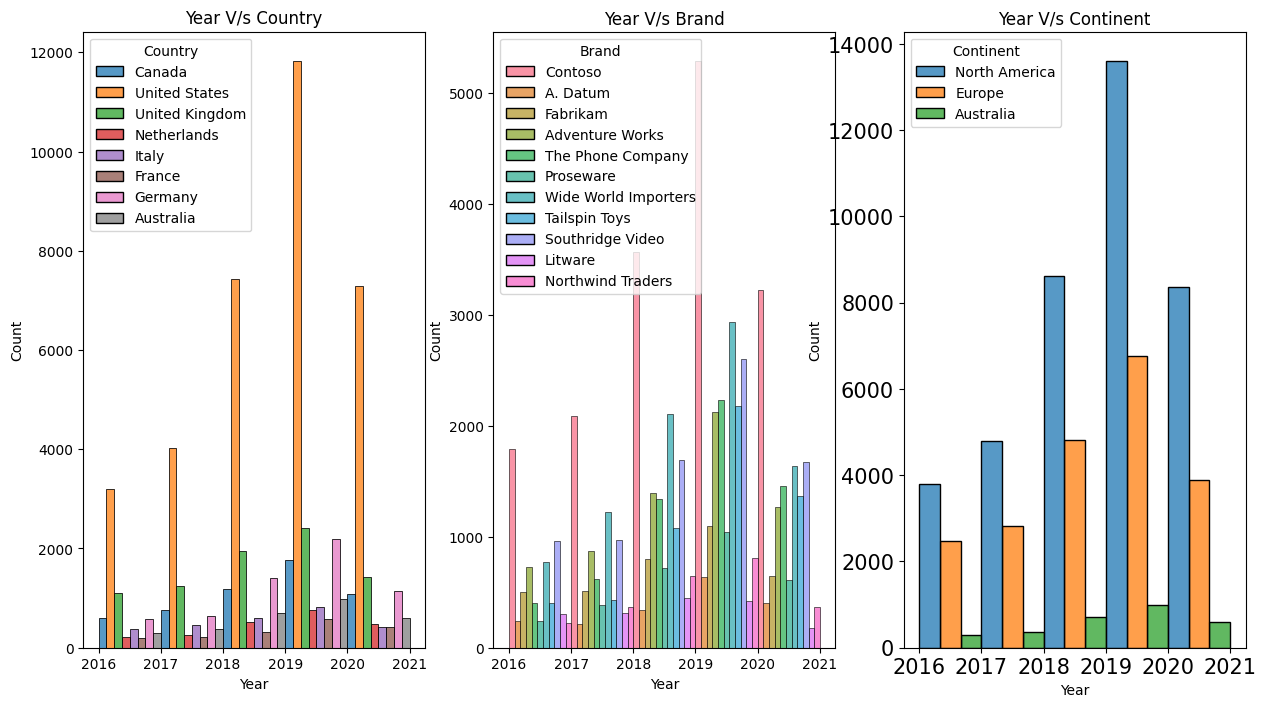

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.histplot(data =df ,bins=5 ,x='Year',hue='Country',multiple='dodge' , ax=axes[0])
sns.histplot(data =df ,bins=5 ,x='Year',hue='Brand',multiple='dodge',ax=axes[1])
sns.histplot(data =df ,bins=5 ,x='Year',hue='Continent',multiple='dodge',ax=axes[2])
axes[0].set_title('Year V/s Country')
axes[1].set_title('Year V/s Brand')
axes[2].set_title('Year V/s Continent')


In [82]:
df['Year'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021], dtype=int32)

ValueError: Could not interpret value `UnitPriceUSD` for `x`. An entry with this name does not appear in `data`.

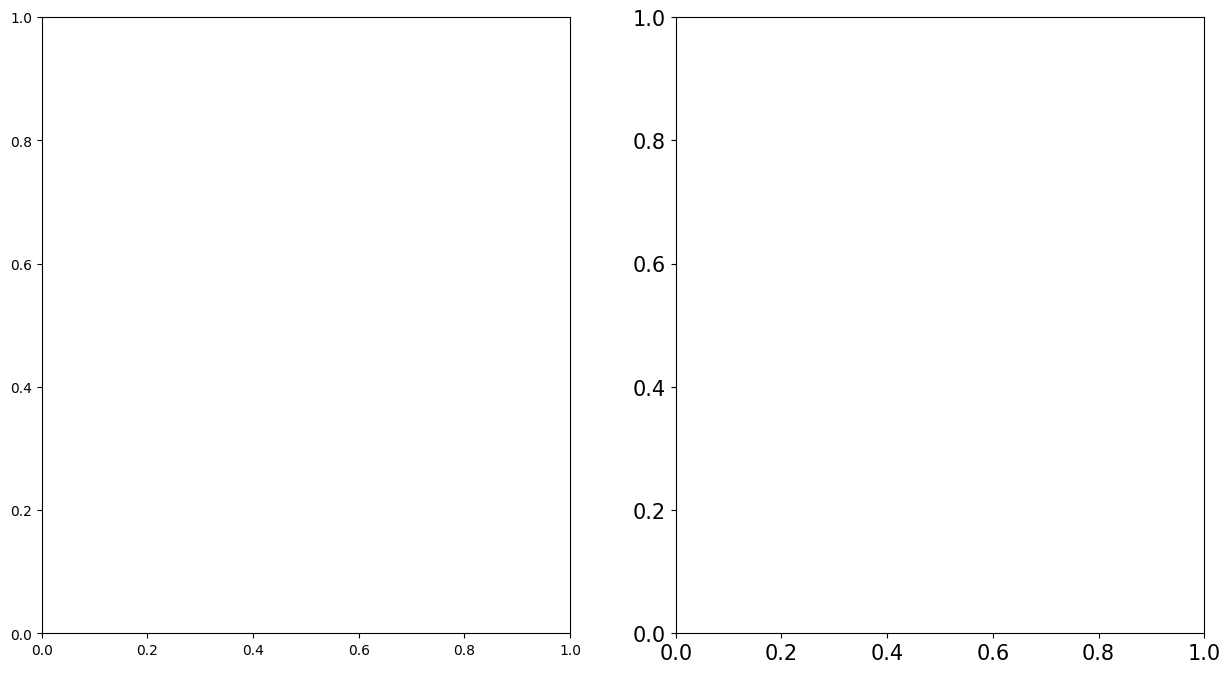

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.histplot(data =df ,bins=5 ,x='UnitPriceUSD',hue='Country',multiple='dodge', ax=axes[0])
sns.histplot(data =df ,bins=5 ,x='UnitPriceUSD',hue='Year',multiple='dodge', ax=axes[1])
axes[0].set_title('Sales Vs Cost acreoss Different Countries')
axes[1].set_title('Sales Vs Cost acreoss Different Years')
plt.tight_layout()  # Adjust spacing between plots
plt.show()


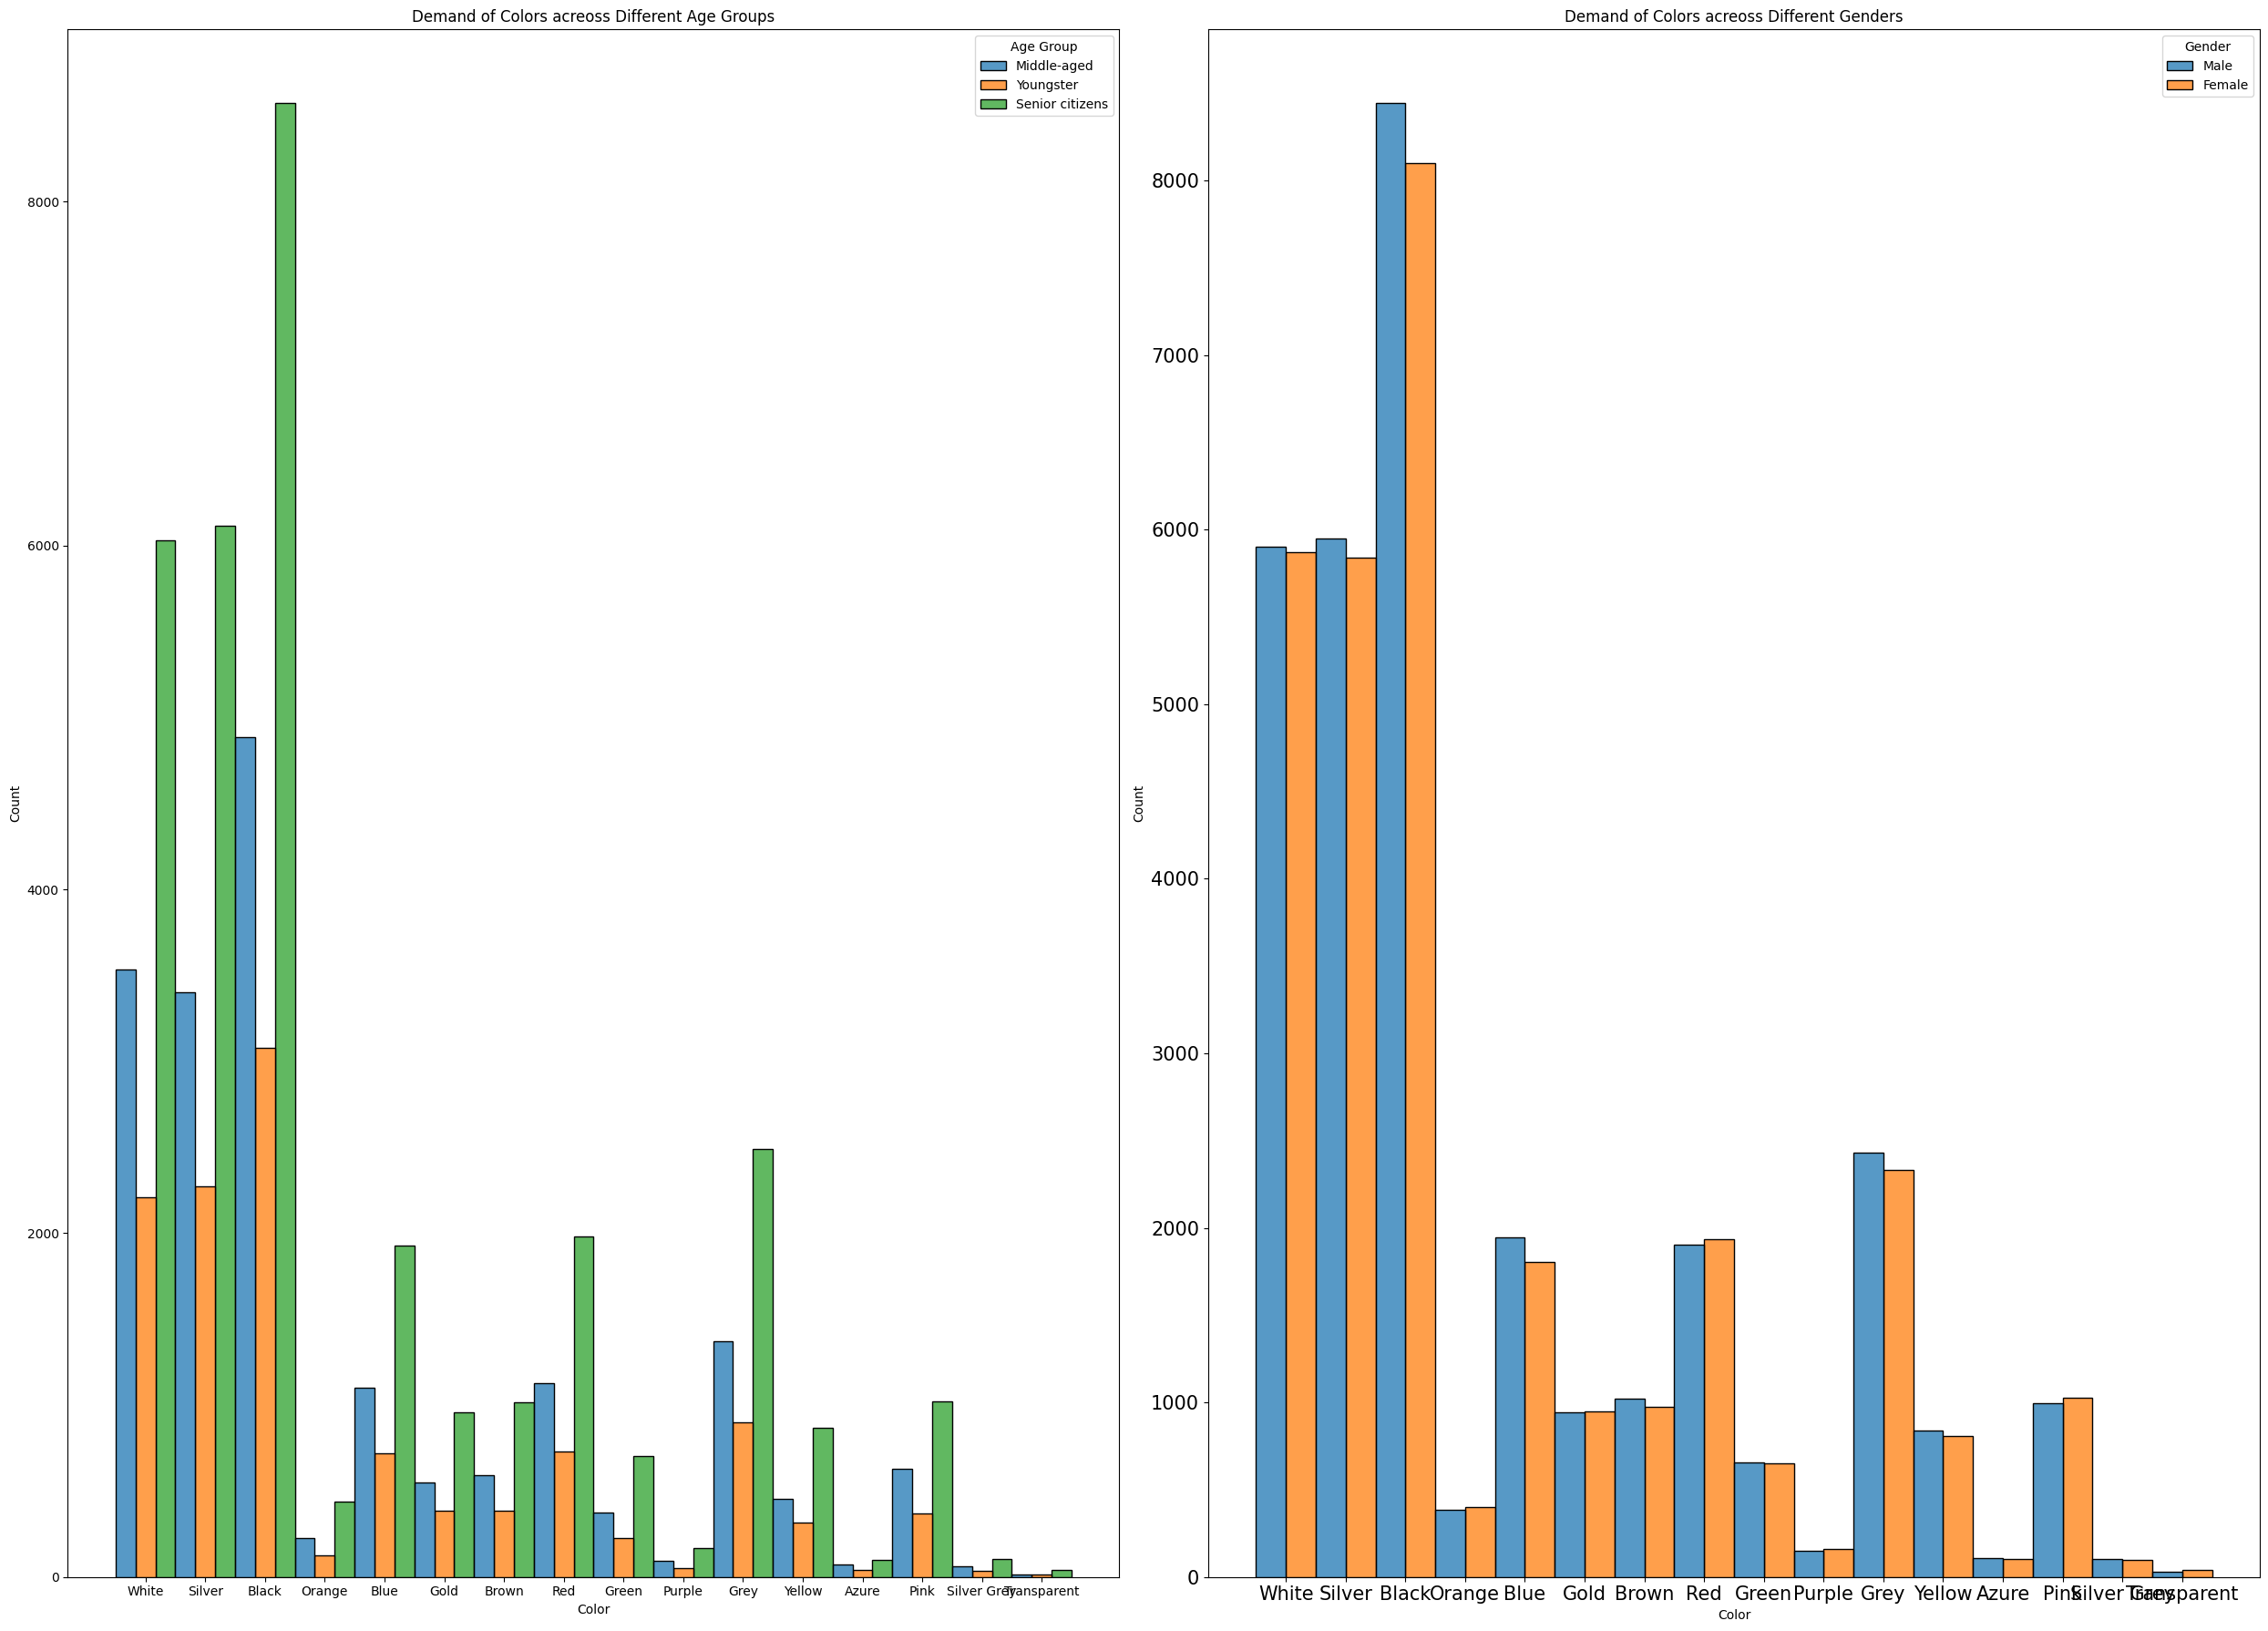

In [84]:

fig, axes = plt.subplots(1, 2, figsize=(25, 18))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.histplot(data =df ,bins=5 ,x='Color',hue='Age Group',multiple='dodge', ax=axes[0])
sns.histplot(data =df ,bins=5 ,x='Color',hue='Gender',multiple='dodge', ax=axes[1])
axes[0].set_title('Demand of Colors acreoss Different Age Groups')
axes[1].set_title('Demand of Colors acreoss Different Genders')
plt.tight_layout()  # Adjust spacing between plots
plt.show()

In [85]:
os.chdir(r'C:\DataSpark\source\repository\processed_data')
df.to_csv(r".\Product_sales_customers.csv")
stores = pd.read_csv(r".\Stores.csv")
stores.drop(columns='Unnamed: 0')

,Unnamed: 0.1,StoreKey,Country,State,Square Meters,Open Date,Category,Store Open Year
0,0,1,Australia,Australian Capital Territory,595.0,1/1/2008,Large,2008
1,1,2,Australia,Northern Territory,665.0,1/12/2008,Large,2008
2,2,3,Australia,South Australia,2000.0,1/7/2012,Extra-large,2012
3,3,4,Australia,Tasmania,2000.0,1/1/2010,Extra-large,2010
4,4,5,Australia,Victoria,2000.0,12/9/2015,Extra-large,2015
...,...,...,...,...,...,...,...,...
62,62,63,United States,Utah,2000.0,3/6/2008,Extra-large,2008
63,63,64,United States,Washington DC,1330.0,1/1/2010,Large,2010
64,64,65,United States,West Virginia,1785.0,1/1/2012,Large,2012
65,65,66,United States,Wyoming,840.0,1/1/2014,Large,2014


In [87]:
df.columns
df = pd.merge(df,stores , on='StoreKey',how='left')
df

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code,Year,...,Category_y,Store Open Year_x,Unnamed: 0.1_y,Unnamed: 0,Country,State,Square Meters_y,Open Date_y,Category,Store Open Year_y
0,366000,1,2016-01-01,2016-01-10 16:00:00.000000002,265598,10,1304,1,CAD,2016,...,Large,2015,9,9,Canada,Nunavut,1210.0,4/4/2015,Large,2015
1,366001,1,2016-01-01,2016-01-13 00:00:00.000000000,1269051,0,1048,2,USD,2016,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
2,366001,2,2016-01-01,2016-01-13 00:00:00.000000000,1269051,0,2007,1,USD,2016,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
3,366002,1,2016-01-01,2016-01-12 00:00:00.000000000,266019,0,1106,7,CAD,2016,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
4,366002,2,2016-01-01,2016-01-12 00:00:00.000000000,266019,0,373,1,CAD,2016,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62879,2243030,1,2021-02-20,2021-02-24 07:59:59.999999997,1216913,43,632,3,USD,2021,...,Large,2015,42,42,United States,Alaska,1190.0,1/1/2015,Large,2015
62880,2243031,1,2021-02-20,2021-02-24 00:00:00.000000000,511229,0,98,4,EUR,2021,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
62881,2243032,1,2021-02-20,2021-02-23 00:00:00.000000000,331277,0,1613,2,CAD,2021,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010
62882,2243032,2,2021-02-20,2021-02-23 00:00:00.000000000,331277,0,1717,2,CAD,2021,...,NaN,2010,66,66,Online,Online,NaN,1/1/2010,NaN,2010


##### Sales from Different stores by Different Age groups

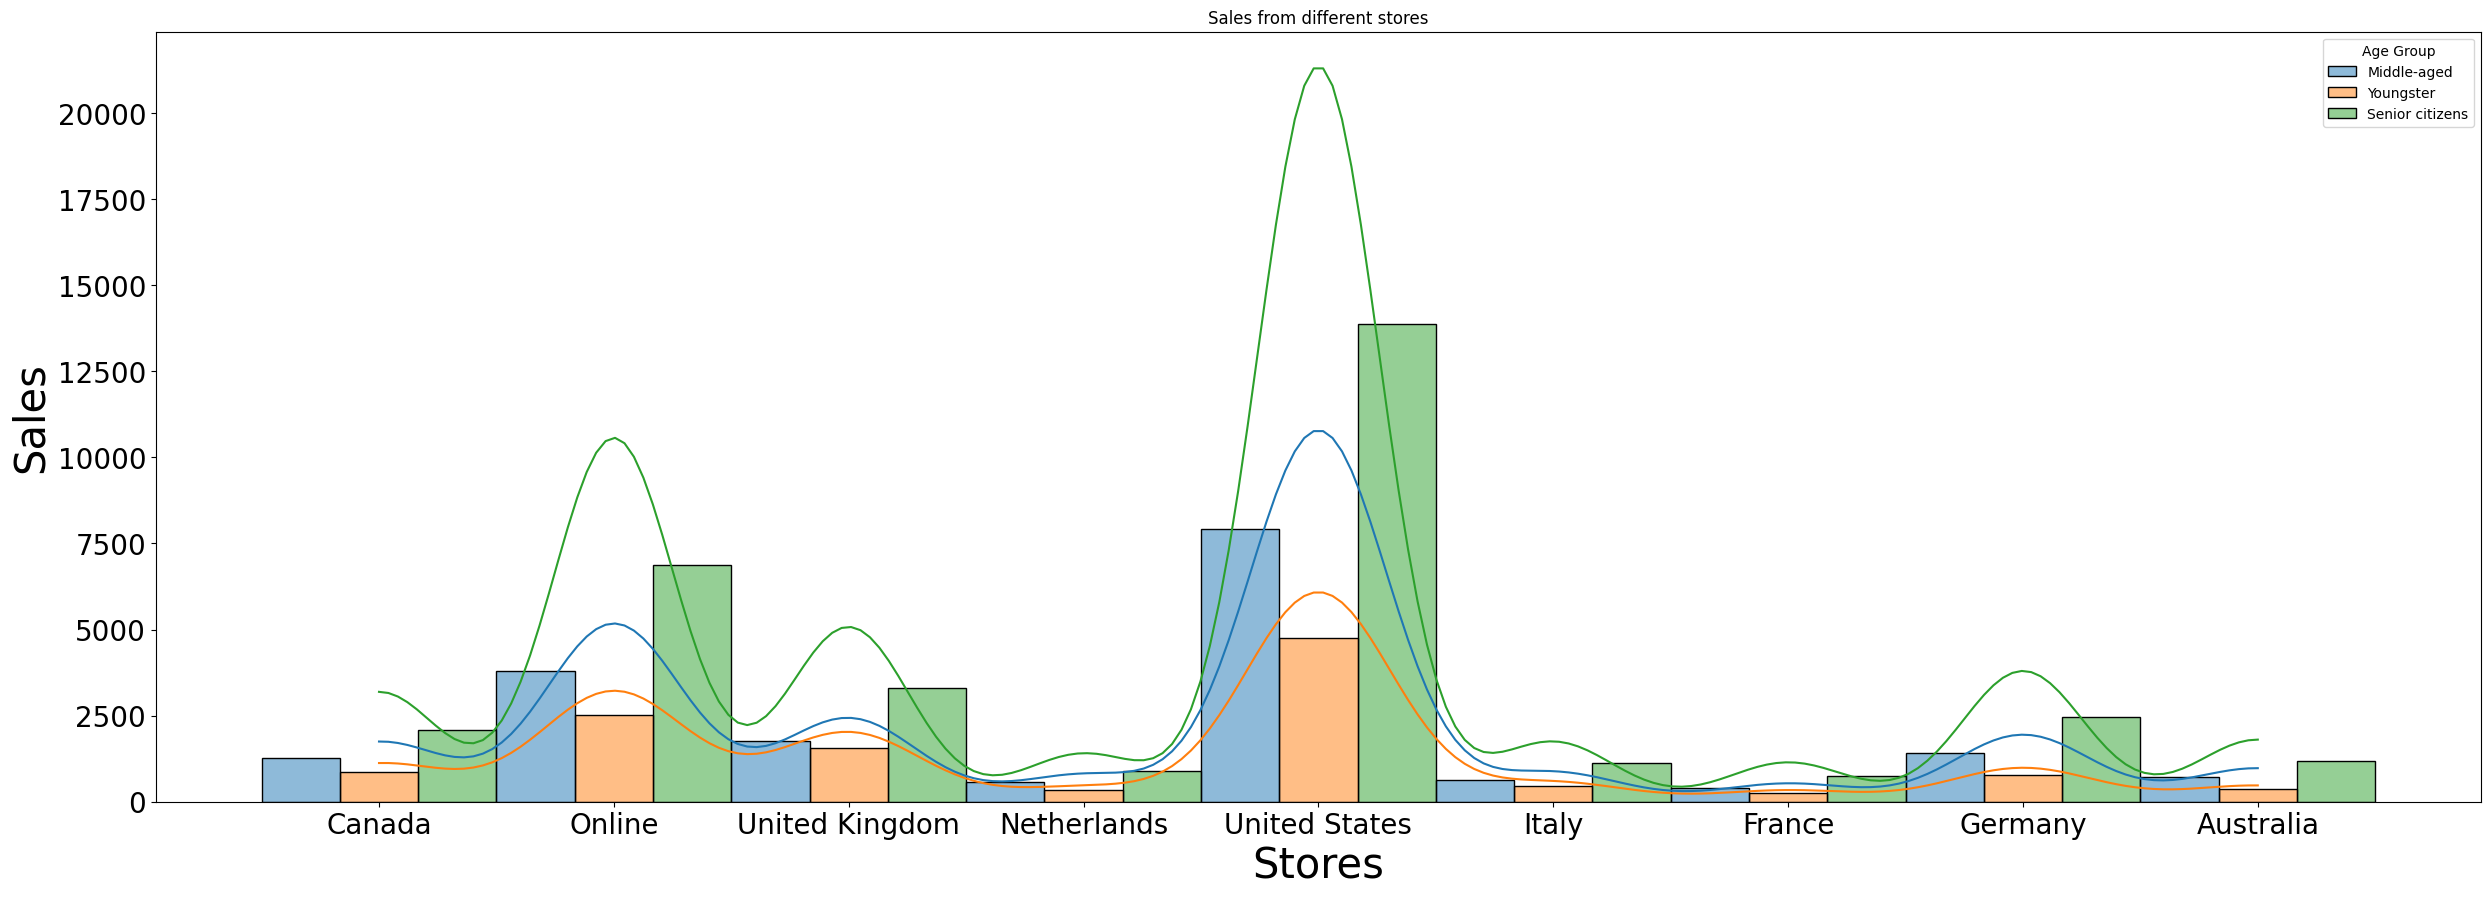

In [88]:

plt.figure(figsize=(30,10))
plt.title("Sales from different stores")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Stores',fontsize=30)
plt.ylabel('Sales',fontsize=30)
sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Age Group',multiple='dodge',kde=True)
#sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Brand',multiple='dodge', ax=axes[1])

plt.show()

##### Sales from Different Stores by Store Size

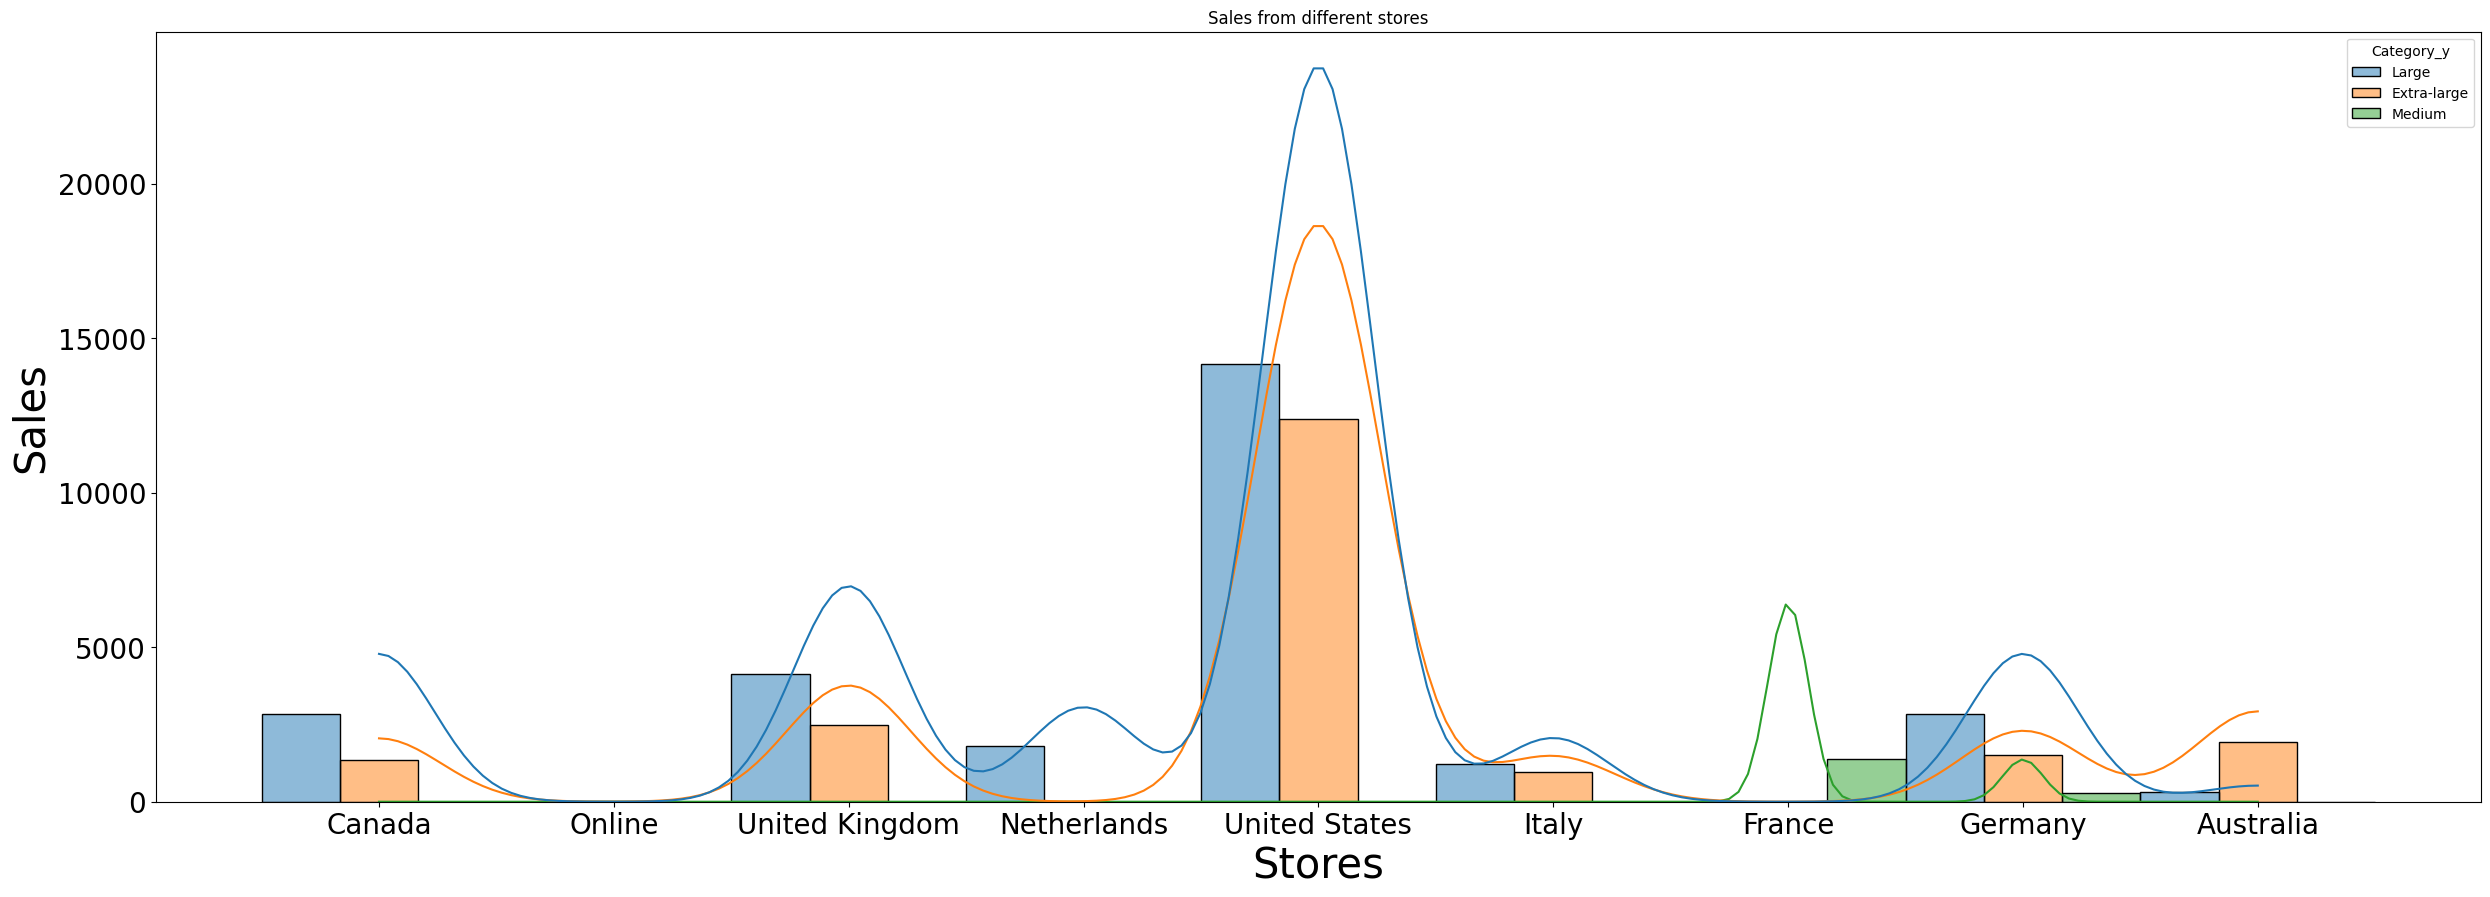

In [89]:

plt.figure(figsize=(30,10))
plt.title("Sales from different stores")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Stores',fontsize=30)
plt.ylabel('Sales',fontsize=30)
sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Category_y',multiple='dodge',kde=True)
#sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Brand',multiple='dodge', ax=axes[1])

plt.show()

##### Stores And Brands

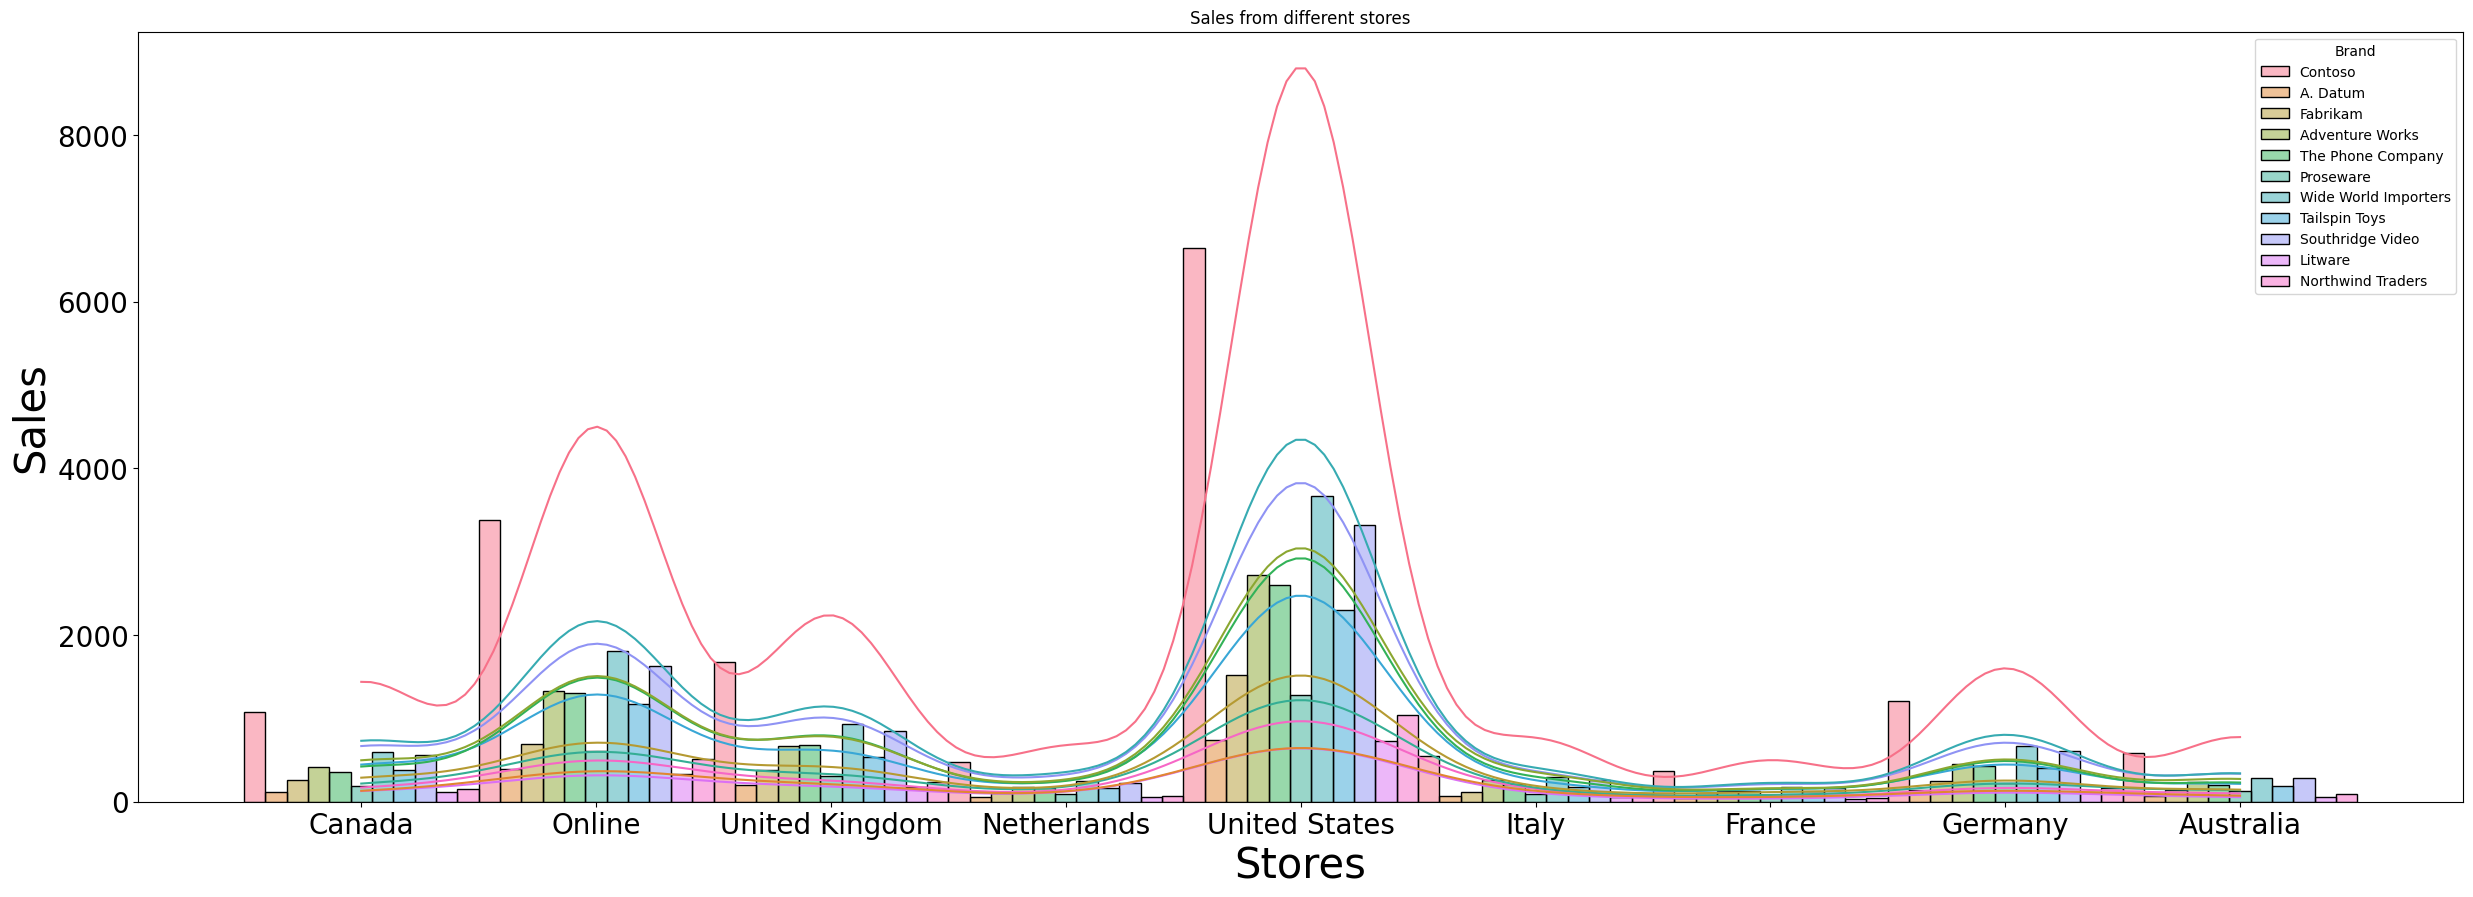

In [90]:

plt.figure(figsize=(30,10))
plt.title("Sales from different stores")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Stores',fontsize=30)
plt.ylabel('Sales',fontsize=30)
sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Brand',multiple='dodge',kde=True)
#sns.histplot(data =df ,bins=5 ,x='Country_y',hue='Brand',multiple='dodge', ax=axes[1])

plt.show()

##### Insights

######  1. Male Senior Citizens are Puchasing More Products 
######  2. Black is the Most demanded Color 
######  3. 'North Wind Traders' is the most demmanded item
######  4. Most of the sale is concentrated on US becouse , Majority of the Large and Extra-Larged size stores are concentrated on the U S .
######  5. Huge amouts of items are sold in 2019 compared to othor years
######  6. Most selling item is of Cost $500

##### Suggestions
###### 1. Most of the business are happening in physical stores , increase online promotoons
###### 2. Build more stores on different Countries